In [1]:
import zipfile
import os
import pandas as pd
import requests
import deflatebr as dbr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sidrapy

In [53]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df = df.rename(columns={df.columns[6]: "cnae_secao"})
            df = df[df['cliente'] == "PJ"]
            df['cnae_secao']=df['cnae_secao'].str.replace('PJ - ','')
            df = df.iloc[:, [0, 6, 20, 22]]
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['mes'] = df['data_base'].dt.month
            df = df[df['mes'] == 12]
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [54]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [56]:
df_total.head(5)

,data_base,cnae_secao,carteira_ativa,ativo_problematico,mes
0,2012-12-31,"Administração pública, defesa e seguridade social",9.665000e+01,96.65,12
1,2012-12-31,"Administração pública, defesa e seguridade social",1.906800e+02,190.68,12
2,2012-12-31,"Administração pública, defesa e seguridade social",3.351102e+04,0.00,12
3,2012-12-31,"Administração pública, defesa e seguridade social",1.034660e+03,0.00,12
4,2012-12-31,"Administração pública, defesa e seguridade social",1.830211e+09,0.00,12


In [57]:
df_total_group = df_total.groupby(['data_base', 'cnae_secao'])[['carteira_ativa', 'ativo_problematico']].sum().reset_index()

In [58]:
df_total_group['data_base'] = df_total_group['data_base'].dt.strftime('%Y') #Converti apenas para o ano porque as séries que vou usar do ibge são anuais

In [60]:
df_total_group.head(5)

,data_base,cnae_secao,carteira_ativa,ativo_problematico
0,2012,"Administração pública, defesa e seguridade social",4.773897e+10,1.342493e+07
1,2012,"Agricultura, pecuária, produção florestal, pes...",1.891586e+10,1.105283e+09
2,2012,Alojamento e alimentação,1.222610e+10,1.141509e+09
3,2012,"Artes, cultura, esporte e recreação",3.389071e+09,1.838335e+08
4,2012,Atividades administrativas e serviços compleme...,3.591193e+10,3.006880e+09


In [6]:
#Extraindo informações do IBGE via api

empresas = sidrapy.table.get_table(
    table_code="2718",
    territorial_level="1",
    ibge_territorial_code="all",
    period="last 9",
    variable="630",
    classifications={"12762": "all", "370": "9504", "369": "all"},
    
)

empresas.columns = empresas.iloc[0] #troca a primeira linha para o nome da coluna
empresas = empresas.iloc[1:, :]

In [7]:
empresas = empresas.drop(columns = ['Nível Territorial', 'Unidade de Medida', 'Nível Territorial (Código)', 'Unidade de Medida (Código)',
                                    'Brasil (Código)', 'Brasil', 'Variável (Código)', 
                                    'Classificação Nacional de Atividades Econômicas (CNAE 2.0) (Código)',
                                    'Faixas de pessoal ocupado assalariado (Código)',
                                    'Faixas de pessoal ocupado assalariado',
                                    'Tipo de evento da empresa (Código)',
                                    'Ano (Código)',
                                   'Variável'])

In [8]:
empresas = empresas.rename(columns={"Classificação Nacional de Atividades Econômicas (CNAE 2.0)": "cnae_secao",
                                     "Tipo de evento da empresa": "evento",
                                    "Valor": "qtde_empresas"}) 

In [9]:
empresas['qtde_empresas'] = empresas['qtde_empresas'].replace("-", np.nan)

In [10]:
empresas['qtde_empresas'] = empresas['qtde_empresas'].astype("float")

In [11]:
empresas_pivot = empresas.pivot_table(index=['Ano', 'cnae_secao'], 
                                      columns='evento', 
                                      values='qtde_empresas').reset_index()

In [13]:
empresas_pivot['cnae_secao'] = empresas_pivot['cnae_secao'].str.slice(start=2)

In [16]:
empresas_pivot.head(3)

evento,Ano,cnae_secao,Entrada,Nascimento,Reentrada,Saída de atividade,Sobrevivente,Total de empresas ativas
0,2013,"Agricultura, pecuária, produção florestal, pes...",6706.0,4745.0,1961.0,5450.0,26487.0,33193.0
1,2013,Indústrias extrativas,2105.0,1393.0,712.0,1545.0,9105.0,11210.0
2,2013,Indústrias de transformação,64665.0,46261.0,18404.0,55564.0,381766.0,446431.0


In [61]:
df_total_group.head(3)

,data_base,cnae_secao,carteira_ativa,ativo_problematico
0,2012,"Administração pública, defesa e seguridade social",4.773897e+10,1.342493e+07
1,2012,"Agricultura, pecuária, produção florestal, pes...",1.891586e+10,1.105283e+09
2,2012,Alojamento e alimentação,1.222610e+10,1.141509e+09


In [62]:
df_corr_ibge_scr_pj = pd.merge(empresas_pivot,
                               df_total_group,
                               left_on = ["Ano", "cnae_secao"],
                               right_on = ["data_base", "cnae_secao"])

In [85]:
df_corr_ibge_scr_pj[df_corr_ibge_scr_pj['cnae_secao'] == "Indústrias extrativas"]

,Ano,cnae_secao,Entrada,Nascimento,Reentrada,Saída de atividade,Sobrevivente,Total de empresas ativas,data_base,carteira_ativa,ativo_problematico
0,2013,Indústrias extrativas,2105.0,1393.0,712.0,1545.0,9105.0,11210.0,2013,2.984883e+10,2.680275e+08
19,2014,Indústrias extrativas,1471.0,1004.0,467.0,2058.0,9138.0,10609.0,2014,3.398217e+10,4.590628e+08
38,2015,Indústrias extrativas,1510.0,947.0,563.0,1623.0,8962.0,10472.0,2015,4.323098e+10,4.704223e+08
57,2016,Indústrias extrativas,1332.0,781.0,551.0,1510.0,8963.0,10295.0,2016,3.298762e+10,1.571414e+09
75,2017,Indústrias extrativas,1315.0,859.0,456.0,1510.0,8752.0,10067.0,2017,2.256922e+10,6.730031e+08
93,2018,Indústrias extrativas,1301.0,866.0,435.0,1657.0,8425.0,9726.0,2018,1.772448e+10,4.456610e+08
112,2019,Indústrias extrativas,2171.0,1476.0,695.0,1162.0,8567.0,10738.0,2019,1.464031e+10,2.514662e+08
131,2020,Indústrias extrativas,1326.0,950.0,376.0,1261.0,9563.0,10889.0,2020,1.625110e+10,4.703231e+08
149,2021,Indústrias extrativas,1715.0,1302.0,413.0,1053.0,9792.0,11507.0,2021,1.415300e+10,1.625135e+09


In [66]:
df_corr_ibge_scr_pj_num = df_corr_ibge_scr_pj.drop(columns = {'Ano',
                                                              'cnae_secao',
                                                             'data_base'}, axis=1)

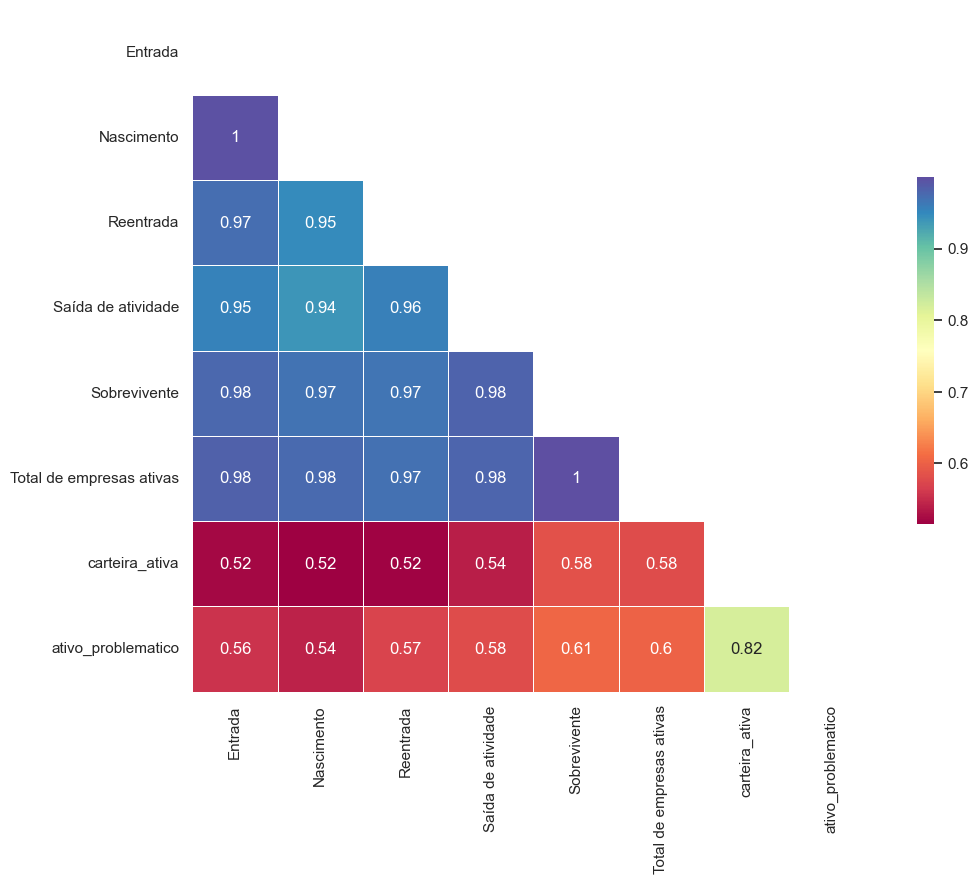

In [80]:
sns.set_theme(style="white")

corr = df_corr_ibge_scr_pj_num.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns_heatmap = sns.heatmap(corr, mask=mask, cmap="Spectral", #possíveis parâmetros para o cmap: https://matplotlib.org/stable/users/explain/colors/colormaps.html
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [88]:
df_scatter_plot = df_corr_ibge_scr_pj.drop(columns = ['Ano'], axis=1)

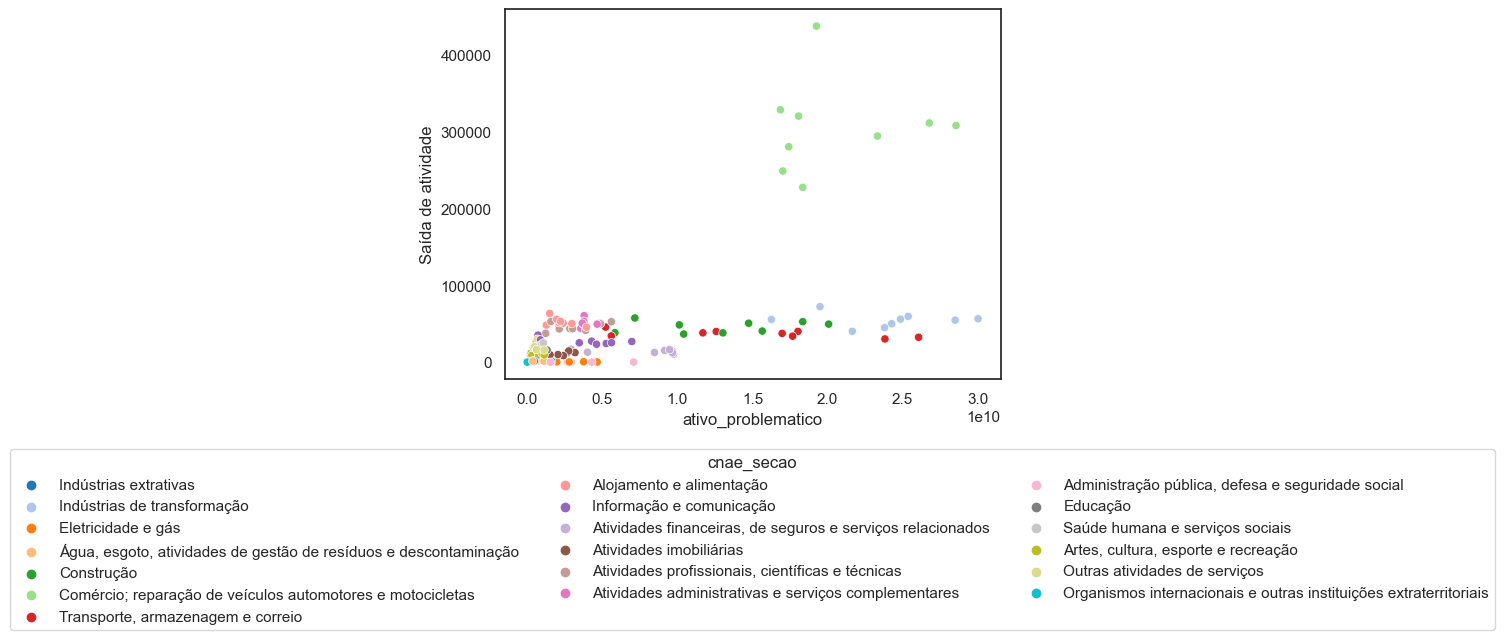

In [89]:
import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette("tab20", 19) #possíveis palettes

sns.scatterplot(data = df_scatter_plot, x="ativo_problematico", y="Saída de atividade", hue = "cnae_secao", palette=palette)
plt.legend(title='cnae_secao', loc='lower center', bbox_to_anchor=(0.5, -0.7), ncol=3)
plt.tight_layout()
plt.show()

In [90]:
df_scatter_plot.to_csv("df_corr_ibge_scr_pj.csv", index=False)